In [11]:
import ccxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
from datetime import datetime
from sklearn.linear_model import LinearRegression

In [3]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    opens = pd.DataFrame(dataframes[0].open).rename(columns={'open':labels[0]})
    for i,coin in enumerate(labels[1:]):
        temp_opens = pd.DataFrame(dataframes[i+1].open).rename(columns={'open':coin})
        opens = opens.merge(temp_opens,how='outer',on='timestamp')
    return (opens)

def load_crypto(days=1000,timeframe='1h',n=30):
    bnc = ccxt.binance()
    symbols = ['BTC','ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    while since <= (bnc.milliseconds()-2000*60*60):
        limit = 1000  # change for your limit
        orders = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        print(bnc.milliseconds()/1000,since/1000)
    combined = pd.concat(all_orders)
    return combined
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i,:]/price_arr[i-1,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i,:]/price_arr[i-1,:])
    log_returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

In [120]:
#loads and writes the data to csv
#opens=load_crypto()
#opens.to_csv('CryptoPrices')

1636058815.252 1553256000.0
1636058827.027 1556852400.0
1636058836.703 1560448800.0
1636058848.107 1564045200.0
1636058859.107 1567641600.0
1636058871.014 1571238000.0
1636058881.752 1574834400.0
1636058892.855 1578430800.0
1636058899.8 1582027200.0
1636058910.173 1585623600.0
1636058933.091 1589220000.0
1636058946.641 1592816400.0
1636058958.848 1596412800.0
1636058967.804 1600009200.0
1636058984.993 1603605600.0
1636059002.08 1607202000.0
1636059015.219 1610798400.0
1636059028.557 1614394800.0
1636059045.549 1617991200.0
1636059059.315 1621587600.0
1636059071.929 1625184000.0
1636059084.894 1628780400.0
1636059101.367 1632376800.0
1636059115.851 1635973200.0
1636059124.949 1636056000.0


In [4]:
opens = pd.read_csv('CryptoPrices').set_index("timestamp")
opens = opens.dropna(axis=0)
returns = get_returns(opens)
log_returns = get_log_returns(opens)

In [5]:
y = np.asarray(log_returns["BTC"])
X = np.asarray(log_returns.drop("BTC",axis=1))

0


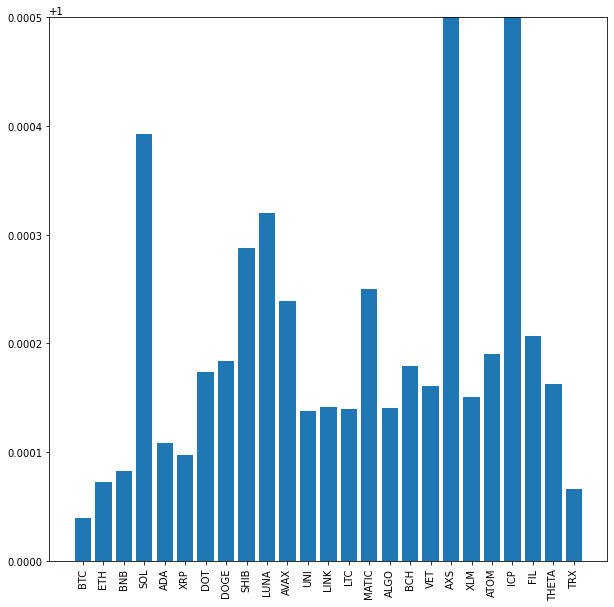

In [175]:
#### use all data as training data because we arn't predicting anything
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)

coeff_df = pd.DataFrame(lm.coef_,log_returns.columns[1:],columns=['Beta'])
coeff_df["R^2"] = lm.score(X,y)
coeff_df['Alpha'] = lm.intercept_
#plt.bar(log_returns.columns[1:], coeff_df["Beta"])
plt.bar(log_returns.columns, desc)
plt.xticks(rotation=90)
plt.ylim(1,1.0005)
print("0")

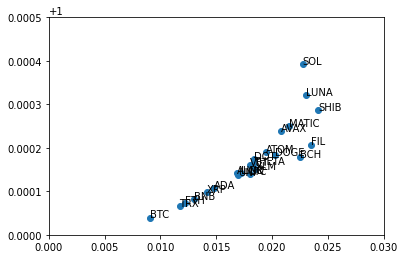

In [6]:
desc = np.asarray(log_returns.describe())[1,:]
std = np.asarray(log_returns.describe())[2,:]
plt.scatter(std,desc)
plt.xlim(0,.03)
plt.ylim(1,1.0005)
for i, txt in enumerate(log_returns.columns):
    plt.annotate(txt, (std[i], desc[i]))

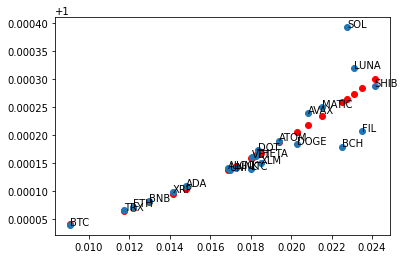

In [46]:
filtered = log_returns.describe().drop(columns=["AXS","ICP"])
desc = np.asarray(filtered)[1,:]
std = np.asarray(filtered)[2,:]


lm2 = LinearRegression()
std2 = np.ones([len(std),3])
std2[:,1] = std
std2[:,2] = std**2
lm2.fit(std2,desc.reshape(-1,1))
predictions = lm2.predict(std2)
plt.scatter(std, predictions,c='r')
plt.scatter(std,desc)
#plt.xlim(0,.03)
#plt.ylim(1,1.0005)
for i, txt in enumerate(filtered.columns):
    plt.annotate(txt, (std[i], desc[i]))